In [2]:
import numpy as np
import copy
import matplotlib.pyplot as plt
from PIL import Image
import os
import math

from sklearn.model_selection import train_test_split


In [3]:
def load_data(data_dir, img_size=(64, 64)):
    X = []
    Y = []

    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            continue


        label = 1 if class_name.lower() == "cats" else 0

        for file in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file)
            try:
                img = Image.open(file_path).resize(img_size).convert("RGB")
                X.append(np.array(img))
                Y.append(label)
            except:
                continue

    X = np.array(X)
    Y = np.array(Y).reshape(1, -1)
    return X, Y


In [4]:
data_dir = "/kaggle/input/cats-vs-noncats/Images/train/" 

X_orig, Y = load_data(data_dir)

In [5]:
X = X_orig / 255.

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y.T, test_size=0.2, random_state=42, stratify=Y.T)

In [7]:
X_train = X_train.transpose(0, 3, 1, 2).transpose(0, 2, 3, 1) 
X_test = X_test.transpose(0, 3, 1, 2).transpose(0, 2, 3, 1)

X_train_flatten = X_train.reshape(X_train.shape[0], -1).T  
X_test_flatten = X_test.reshape(X_test.shape[0], -1).T

Y_train = Y_train.T 
Y_test = Y_test.T

print(f"train_set_x_flatten shape: {X_train_flatten.shape}")
print(f"train_set_y shape: {Y_train.shape}")
print(f"test_set_x_flatten shape: {X_test_flatten.shape}")
print(f"test_set_y shape: {Y_test.shape}")


train_set_x_flatten shape: (12288, 12809)
train_set_y shape: (1, 12809)
test_set_x_flatten shape: (12288, 3203)
test_set_y shape: (1, 3203)


y = [0], it's a 'not_cat' picture.


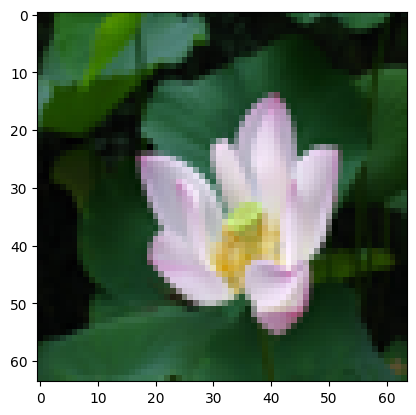

In [10]:
classes = np.array([b"not_cat", b"cat"])
index = 45
plt.imshow(X_orig[index])
print("y = " + str(Y[:, index]) + ", it's a '" +
      classes[np.squeeze(Y[:, index])].decode("utf-8") + "' picture.")

# L Hidden Layer Neural Network 

In [49]:
class LLayerNeuralNetwork:

    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))

    def relu(self, Z):
        return np.maximum(0, Z)

    def initialize_parameters(self, layer_dims, activation="relu"):
        np.random.seed(3)
        L = len(layer_dims)
        parameters = {}
        if activation == "relu":
            for l in range(1, L):
                if l == L - 1:
                    parameters["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(1 / layer_dims[l-1])
                else:
                    parameters["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2 / layer_dims[l-1])
                parameters["b" + str(l)] = np.zeros((layer_dims[l], 1))
        elif activation == "tanh":
            for l in range(1, L):
                parameters["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(1 / layer_dims[l-1])
                parameters["b" + str(l)] = np.zeros((layer_dims[l], 1))
        else:
            raise ValueError("Unsupported initialization activation")
        return parameters

    def linear_forward(self, A, W, b):
        return np.dot(W, A) + b

    def linear_activation_forward(self, A_prev, W, b, activation):
        Z = self.linear_forward(A_prev, W, b)
        if activation == "sigmoid":
            A = self.sigmoid(Z)
        elif activation == "relu":
            A = self.relu(Z)
        else:
            raise ValueError("Unsupported activation function")
        return A, (A_prev, W, b, Z)

    def L_model_forward(self, X, parameters):
        caches = []
        A = X
        L = len(parameters) // 2
        for l in range(1, L):
            A_prev = A
            A, cache = self.linear_activation_forward(A_prev, parameters["W"+str(l)], parameters["b"+str(l)], "relu")
            caches.append(cache)
        AL, cache = self.linear_activation_forward(A, parameters["W"+str(L)], parameters["b"+str(L)], "sigmoid")
        caches.append(cache)
        return AL, caches

    def compute_cost(self, AL, Y):
        m = Y.shape[1]
        cost = (-1/m) * np.sum(Y * np.log(AL + 1e-8) + (1 - Y) * np.log(1 - AL + 1e-8))
        return np.squeeze(cost)

    def compute_cost_l2_regularization(self, AL, Y, parameters, lambd):
        m = Y.shape[1]
        cross_entropy_cost = self.compute_cost(AL, Y)
        L = len(parameters) // 2
        l2_sum = 0
        for l in range(1, L+1):
            l2_sum += np.sum(np.square(parameters["W"+str(l)]))
        L2_regularization_cost = (lambd / (2 * m)) * l2_sum
        return cross_entropy_cost + L2_regularization_cost

    def relu_backward(self, dA, Z):
        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0
        return dZ

    def sigmoid_backward(self, dA, Z):
        A = self.sigmoid(Z)
        return dA * A * (1 - A)

    def linear_backward(self, dZ, A_prev, W, b, lambd):
        m = A_prev.shape[1]
        dW = (1 / m) * np.dot(dZ, A_prev.T) + (lambd / m) * W
        db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
        dA_prev = np.dot(W.T, dZ)
        return dA_prev, dW, db

    def linear_activation_backward(self, dA, A_prev, W, b, Z, activation, lambd):
        if activation == "relu":
            dZ = self.relu_backward(dA, Z)
        elif activation == "sigmoid":
            dZ = self.sigmoid_backward(dA, Z)
        else:
            raise ValueError("Unsupported activation")
        return self.linear_backward(dZ, A_prev, W, b, lambd)

    def L_model_backward(self, AL, Y, caches, lambd):
        grads = {}
        L = len(caches)
        m = AL.shape[1]
        Y = Y.reshape(AL.shape)

        dAL = -(np.divide(Y, AL + 1e-8) - np.divide(1 - Y, 1 - AL + 1e-8))
        current_cache = caches[L-1]
        dA_prev, dW, db = self.linear_activation_backward(dAL, *current_cache, "sigmoid", lambd)

        grads["dA" + str(L-1)] = dA_prev
        grads["dW" + str(L)] = dW
        grads["db" + str(L)] = db

        for l in reversed(range(L-1)):
            current_cache = caches[l]
            dA_prev, dW, db = self.linear_activation_backward(grads["dA" + str(l+1)], *current_cache, "relu", lambd)
            grads["dA" + str(l)] = dA_prev
            grads["dW" + str(l+1)] = dW
            grads["db" + str(l+1)] = db

        return grads

    def update_parameters(self, learning_rate, parameters, grads):
        L = len(parameters) // 2
        for l in range(1, L+1):
            parameters["W" + str(l)] -= learning_rate * grads["dW" + str(l)]
            parameters["b" + str(l)] -= learning_rate * grads["db" + str(l)]
        return parameters

    def initialize_adam(self, parameters):
        L = len(parameters) // 2
        v = {}
        s = {}
        for l in range(1, L+1):
            v["dW" + str(l)] = np.zeros_like(parameters["W" + str(l)])
            v["db" + str(l)] = np.zeros_like(parameters["b" + str(l)])
            s["dW" + str(l)] = np.zeros_like(parameters["W" + str(l)])
            s["db" + str(l)] = np.zeros_like(parameters["b" + str(l)])
        return v, s

    def update_parameters_with_adam(self, parameters, grads, v, s, t,
                                    learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
        L = len(parameters) // 2
        v_corrected = {}
        s_corrected = {}

        for l in range(1, L+1):
            # Momentum
            v["dW" + str(l)] = beta1 * v["dW" + str(l)] + (1 - beta1) * grads["dW" + str(l)]
            v["db" + str(l)] = beta1 * v["db" + str(l)] + (1 - beta1) * grads["db" + str(l)]

            v_corrected["dW" + str(l)] = v["dW" + str(l)] / (1 - beta1**t)
            v_corrected["db"+ str(l)] = v["db" + str(l)] / (1 - beta1**t)

            # RMSProp
            s["dW" + str(l)] = beta2 * s["dW" + str(l)] + (1 - beta2) * (grads["dW" + str(l)] ** 2)
            s["db" + str(l)] = beta2 * s["db" + str(l)] + (1 - beta2) * (grads["db" + str(l)] ** 2)

            s_corrected["dW" + str(l)] = s["dW" + str(l)] / (1 - beta2**t)
            s_corrected["db" + str(l)] = s["db" + str(l)] / (1 - beta2**t)

            # Update
            parameters["W" + str(l)] -= learning_rate * v_corrected["dW" + str(l)] / (np.sqrt(s_corrected["dW" + str(l)]) + epsilon)
            parameters["b" + str(l)] -= learning_rate * v_corrected["db" + str(l)] / (np.sqrt(s_corrected["db" + str(l)]) + epsilon)

        return parameters, v, s

    def learning_rate_decay(self, start_learning_rate, decay_type, epoch_num, decay_rate):
        if decay_type == "inverse_time":
            return start_learning_rate / (1 + decay_rate * epoch_num)
        elif decay_type == "staircase":
            return start_learning_rate / (2 ** (epoch_num // 100))
        elif decay_type == "exponential":
            return start_learning_rate * (decay_rate ** epoch_num)
        else:
            return start_learning_rate

    def random_mini_batches(self, X, Y, mini_batch_size, seed=0):
        np.random.seed(seed)
        m = X.shape[1]
        mini_batches = []

        permutation = list(np.random.permutation(m))
        shuffled_X = X[:, permutation]
        shuffled_Y = Y[:, permutation].reshape((1, m))

        num_complete_minibatches = math.floor(m / mini_batch_size)
        for k in range(num_complete_minibatches):
            mini_batch_X = shuffled_X[:, k*mini_batch_size:(k+1)*mini_batch_size]
            mini_batch_Y = shuffled_Y[:, k*mini_batch_size:(k+1)*mini_batch_size]
            mini_batches.append((mini_batch_X, mini_batch_Y))

        if m % mini_batch_size != 0:
            mini_batch_X = shuffled_X[:, num_complete_minibatches*mini_batch_size:]
            mini_batch_Y = shuffled_Y[:, num_complete_minibatches*mini_batch_size:]
            mini_batches.append((mini_batch_X, mini_batch_Y))

        return mini_batches

    def train(self, X, Y, layers_dims, learning_rate=0.0075, num_iterations=3000, print_cost=False,
              decay_type=None, decay_rate=0.01, mini_batch_size=None, optimizer="gd",
              beta1=0.9, beta2=0.999, epsilon=1e-8, seed=1, lambd=0.0):

        parameters = self.initialize_parameters(layers_dims, activation="relu")
        costs = []
        initial_learning_rate = learning_rate
        t = 0  # Adam timestep counter

        # Normalize input once and save mean/std for prediction
        self.X_mean = np.mean(X, axis=1, keepdims=True)
        self.X_std = np.std(X, axis=1, keepdims=True) + 1e-8
        X = (X - self.X_mean) / self.X_std

        if optimizer == "adam":
            self.v, self.s = self.initialize_adam(parameters)

        for i in range(num_iterations):
            epoch_cost = 0
            if mini_batch_size is None:
                mini_batches = [(X, Y)]
            else:
                mini_batches = self.random_mini_batches(X, Y, mini_batch_size, seed + i)

            for mini_batch_X, mini_batch_Y in mini_batches:
                AL, caches = self.L_model_forward(mini_batch_X, parameters)
                if lambd == 0:
                    cost = self.compute_cost(AL, mini_batch_Y)
                else:
                    cost = self.compute_cost_l2_regularization(AL, mini_batch_Y, parameters, lambd)

                grads = self.L_model_backward(AL, mini_batch_Y, caches, lambd)

                if optimizer == "gd":
                    parameters = self.update_parameters(learning_rate, parameters, grads)
                elif optimizer == "adam":
                    t += 1
                    parameters, self.v, self.s = self.update_parameters_with_adam(parameters, grads, self.v, self.s, t,
                                                                                 learning_rate, beta1, beta2, epsilon)
                else:
                    raise ValueError("Unsupported optimizer")

                epoch_cost += cost / len(mini_batches)

            if decay_type:
                learning_rate = self.learning_rate_decay(initial_learning_rate, decay_type, i, decay_rate)

            if print_cost and i % 100 == 0:
                print(f"Cost after iteration {i}: {epoch_cost:.6f}")
                costs.append(epoch_cost)

        return parameters, costs

    def predict(self, X, parameters):
        X = (X - self.X_mean) / self.X_std
        AL, _ = self.L_model_forward(X, parameters)
        return (AL > 0.5).astype(int)

    # Optional: evaluation metrics
    def accuracy(self, predictions, Y):
        return np.mean(predictions == Y) * 100

    def precision(self, predictions, Y):
        tp = np.sum(np.logical_and(predictions == 1, Y == 1))
        fp = np.sum(np.logical_and(predictions == 1, Y == 0))
        precision = tp / (tp + fp + 1e-8)
        return precision

    def recall(self, predictions, Y):
        tp = np.sum(np.logical_and(predictions == 1, Y == 1))
        fn = np.sum(np.logical_and(predictions == 0, Y == 1))
        recall = tp / (tp + fn + 1e-8)
        return recall

    def f1_score(self, predictions, Y):
        precision = self.precision(predictions, Y)
        recall = self.recall(predictions, Y)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
        return f1 * 100

    

In [50]:
nn = LLayerNeuralNetwork()
parameters, costs = nn.train(X_train_flatten, Y_train, layers_dims=[X_train_flatten.shape[0], 20, 7, 5, 1], 
                            learning_rate=0.0075, num_iterations=2000, print_cost=True,
                             optimizer="adam", lambd=0.1)

Cost after iteration 0: 0.713001
Cost after iteration 100: 0.248061
Cost after iteration 200: 0.073306
Cost after iteration 300: 0.085850
Cost after iteration 400: 0.027497
Cost after iteration 500: 0.014640
Cost after iteration 600: 0.010371
Cost after iteration 700: 0.008641
Cost after iteration 800: 0.007699
Cost after iteration 900: 0.006994
Cost after iteration 1000: 0.006462
Cost after iteration 1100: 0.006011
Cost after iteration 1200: 0.005659
Cost after iteration 1300: 0.005332
Cost after iteration 1400: 0.004955
Cost after iteration 1500: 0.004676
Cost after iteration 1600: 0.004418
Cost after iteration 1700: 0.004174
Cost after iteration 1800: 0.003949
Cost after iteration 1900: 0.003727


In [51]:
pred_train = nn.predict(X_train_flatten,parameters)
train_acc = nn.accuracy(pred_train, Y_train)

pred_test = nn.predict(X_test_flatten,parameters)
test_acc = nn.accuracy(pred_test, Y_test)

print(f"Train Accuracy: {train_acc:.2f}")
print(f"Test Accuracy: {test_acc:.2f}")

Train Accuracy: 99.98
Test Accuracy: 85.86


In [52]:
train_f1 = nn.f1_score(pred_train,Y_train)
test_f1 = nn.f1_score(pred_test,Y_test)

print(f"Train F1-score: {train_f1:.2f}")
print(f"Test F1-score: {test_f1:.2f}")

Train F1-score: 99.98
Test F1-score: 88.81
